# **Quantum Derivatives Pricing**
## Quantum Monte Carlo Simulation - A Finance Use Case



####**Author / Date**

**[qubit-lab.ch](http://qubit-lab.ch)** / July 2025  

####**Versions used**
- Python 3.10.9
- Qiskit 1.1.0 (see first cell)

####Find an explaining video and further resources on **[qubit-lab.ch](http://qubit-lab.ch)**


# Classical Monte Carlo for European Option

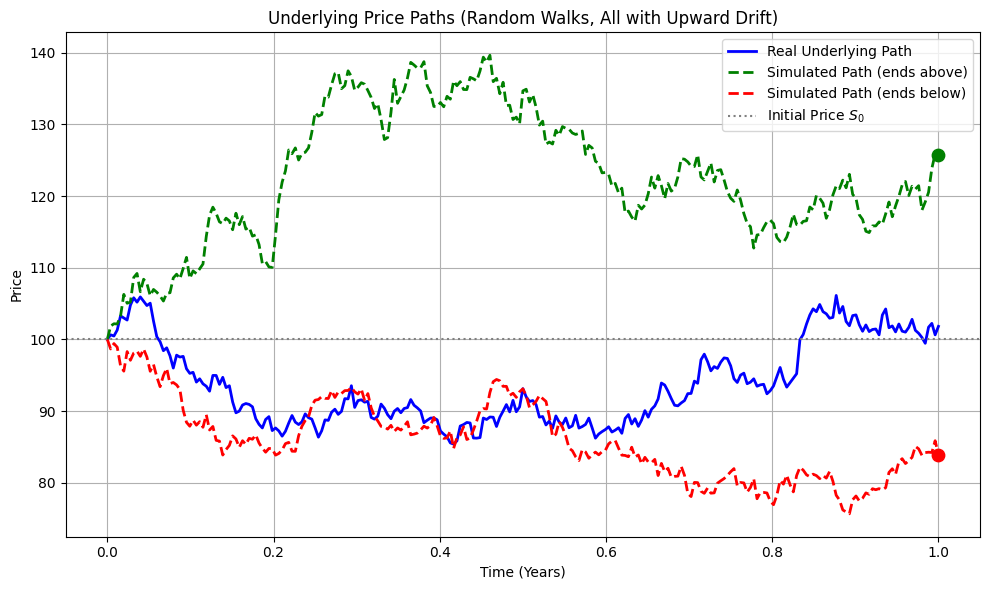

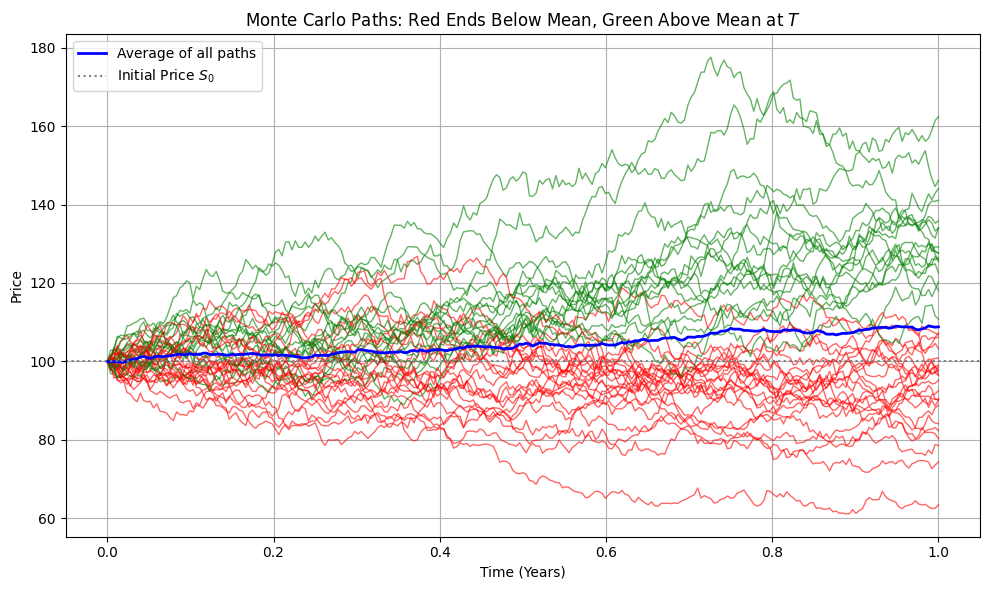

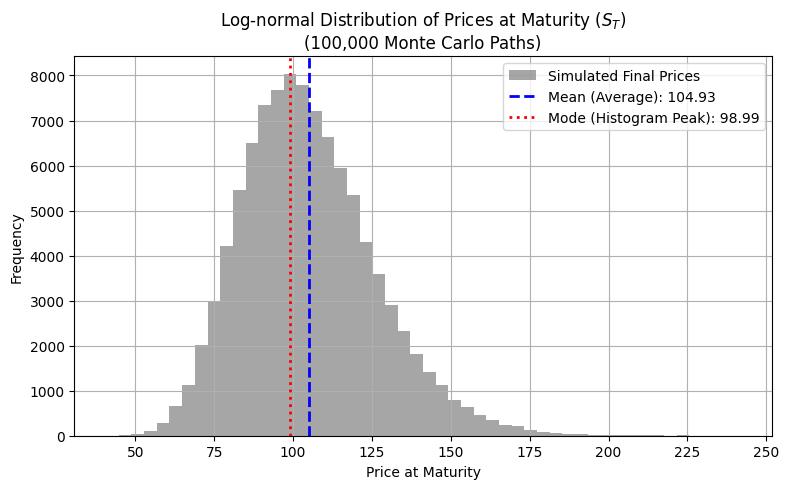

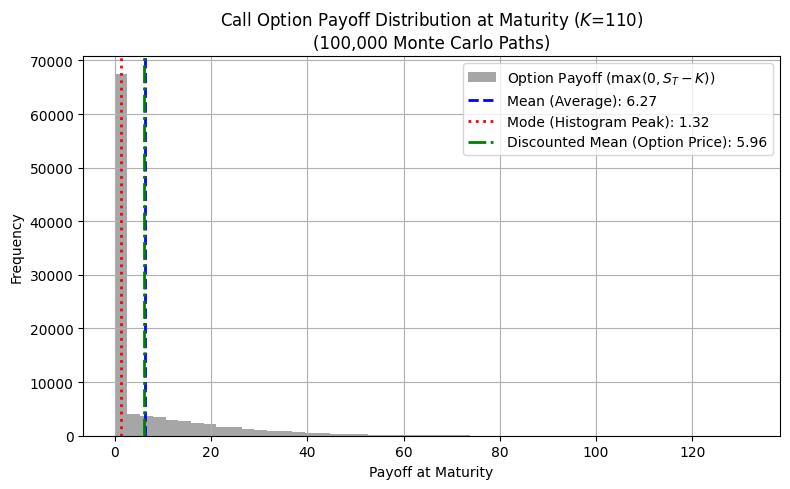

Strike (K) | Monte Carlo Price | Black-Scholes Price
----------------------------------------------------
        80 |           24.4154 |             24.5888
        90 |           16.5472 |             16.6994
       100 |           10.3349 |             10.4506
       110 |            5.9645 |              6.0401
       120 |            3.1978 |              3.2475


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ----- PARAMETERS -----
S0 = 100      # Underlying's price at Start 100 USD
r = 0.05      # Risk free rate
sigma = 0.2   # Underlying's volatility 20%
T = 1.0       # Duration 1 year
N = 252       # Timesteps
dt = T / N
time = np.linspace(0, T, N+1)
num_paths = 100000  # Use 100000 for smoother histograms

# -----------------------------
# 1. UNDERLYING PRICE PATHS PLOT (Random Walks With Upward Drift)
# -----------------------------
# Realistic "historical-like" path
np.random.seed(42)
real_returns = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), N)
real_price_path = S0 * np.exp(np.cumsum(np.insert(real_returns, 0, 0)))

# One random path ending above S0
np.random.seed(100)
while True:
    sim_returns_above = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), N)
    sim_path_above = S0 * np.exp(np.cumsum(np.insert(sim_returns_above, 0, 0)))
    if sim_path_above[-1] > S0 * 1.1:
        break

# One random path ending below S0
np.random.seed(200)
while True:
    sim_returns_below = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), N)
    sim_path_below = S0 * np.exp(np.cumsum(np.insert(sim_returns_below, 0, 0)))
    if sim_path_below[-1] < S0 * 0.9:
        break

plt.figure(figsize=(10, 6))
plt.plot(time, real_price_path, label='Real Underlying Path', linewidth=2, color='blue')
plt.plot(time, sim_path_above, label='Simulated Path (ends above)', linestyle='--', color='green', linewidth=2)
plt.plot(time, sim_path_below, label='Simulated Path (ends below)', linestyle='--', color='red', linewidth=2)
plt.axhline(y=S0, color='gray', linestyle=':', label='Initial Price $S_0$')
plt.scatter([T], [sim_path_above[-1]], color='green', s=80, zorder=5)
plt.scatter([T], [sim_path_below[-1]], color='red', s=80, zorder=5)
plt.title('Underlying Price Paths (Random Walks, All with Upward Drift)')
plt.xlabel('Time (Years)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. MONTE CARLO ENSEMBLE: Show Many Paths and Their Mean
# -----------------------------
num_mc_paths = 40  # For visual clarity; use 10000 for large MC plots later
np.random.seed(777)
all_mc_paths = []
for _ in range(num_mc_paths):
    mc_returns = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), N)
    mc_path = S0 * np.exp(np.cumsum(np.insert(mc_returns, 0, 0)))
    all_mc_paths.append(mc_path)
all_mc_paths = np.array(all_mc_paths)
mean_path = np.mean(all_mc_paths, axis=0)

# -----------------------------
# 3. MONTE CARLO ENSEMBLE: Color by Ending Above or Below Mean
# -----------------------------
final_mean = mean_path[-1]
plt.figure(figsize=(10, 6))
for path in all_mc_paths:
    if path[-1] >= final_mean:
        plt.plot(time, path, color='green', alpha=0.6, linewidth=1)
    else:
        plt.plot(time, path, color='red', alpha=0.6, linewidth=1)
plt.plot(time, mean_path, color='blue', linewidth=2, label='Average of all paths')
plt.axhline(y=S0, color='gray', linestyle=':', label='Initial Price $S_0$')
plt.title('Monte Carlo Paths: Red Ends Below Mean, Green Above Mean at $T$')
plt.xlabel('Time (Years)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 4. HISTOGRAM OF FINAL PRICES (Log-normal at Maturity)
# -----------------------------
# Now, increase the number of MC paths for a smooth histogram
num_paths = 100000
np.random.seed(777)
all_mc_paths = []
for _ in range(num_paths):
    mc_returns = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), N)
    mc_path = S0 * np.exp(np.cumsum(np.insert(mc_returns, 0, 0)))
    all_mc_paths.append(mc_path)
all_mc_paths = np.array(all_mc_paths)
final_prices = all_mc_paths[:, -1]

# Calculate mean and mode of final prices
mean_final = np.mean(final_prices)
counts, bin_edges = np.histogram(final_prices, bins=50)
mode_index = np.argmax(counts)
mode_final = 0.5 * (bin_edges[mode_index] + bin_edges[mode_index + 1])

plt.figure(figsize=(8, 5))
plt.hist(final_prices, bins=50, color='gray', alpha=0.7, label='Simulated Final Prices')
plt.axvline(mean_final, color='blue', linestyle='--', linewidth=2, label=f'Mean (Average): {mean_final:.2f}')
plt.axvline(mode_final, color='red', linestyle=':', linewidth=2, label=f'Mode (Histogram Peak): {mode_final:.2f}')
plt.title('Log-normal Distribution of Prices at Maturity ($S_T$)\n(100,000 Monte Carlo Paths)')
plt.xlabel('Price at Maturity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 5. HISTOGRAM OF PAYOFFS (Call Option)
# -----------------------------
K = 110  # Example strike
payoffs = np.maximum(0, final_prices - K)
mean_payoff = np.mean(payoffs)
counts_payoff, bin_edges_payoff = np.histogram(payoffs, bins=50)
mode_index_payoff = np.argmax(counts_payoff)
mode_payoff = 0.5 * (bin_edges_payoff[mode_index_payoff] + bin_edges_payoff[mode_index_payoff + 1])
discount_factor = np.exp(-r * T)
discounted_mean_payoff = mean_payoff * discount_factor

plt.figure(figsize=(8, 5))
plt.hist(payoffs, bins=50, color='gray', alpha=0.7, label='Option Payoff ($\\max(0, S_T - K)$)')
plt.axvline(mean_payoff, color='blue', linestyle='--', linewidth=2,
            label=f'Mean (Average): {mean_payoff:.2f}')
plt.axvline(mode_payoff, color='red', linestyle=':', linewidth=2,
            label=f'Mode (Histogram Peak): {mode_payoff:.2f}')
plt.axvline(discounted_mean_payoff, color='green', linestyle='-.', linewidth=2,
            label=f'Discounted Mean (Option Price): {discounted_mean_payoff:.2f}')
plt.title(f'Call Option Payoff Distribution at Maturity ($K$={K})\n(100,000 Monte Carlo Paths)')
plt.xlabel('Payoff at Maturity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 6. MC vs. Black-Scholes Table
# -----------------------------
def mc_option_price(final_prices, K, r, T):
    payoffs = np.maximum(0, final_prices - K)
    discounted_mean_payoff = np.mean(payoffs) * np.exp(-r * T)
    return discounted_mean_payoff

def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call

Ks = [80, 90, 100, 110, 120]
prices = [mc_option_price(final_prices, K, r, T) for K in Ks]
bs_prices = [black_scholes_call(S0, K, T, r, sigma) for K in Ks]

print(f"{'Strike (K)':>10} | {'Monte Carlo Price':>10} | {'Black-Scholes Price':>10}")
print("-" * 52)
for K, mc_price, bs_price in zip(Ks, prices, bs_prices):
    print(f"{K:>10} | {mc_price:>17.4f} | {bs_price:>19.4f}")


#**Installing Qiskit in a previous, running version**

In [2]:
!pip install qiskit==2.0.0 qiskit-aer qiskit-finance numpy matplotlib scipy --quiet

# Quantum Monte Carlo to Price European Call Option


Quantum-Estimated Price (K=110): 6.2734


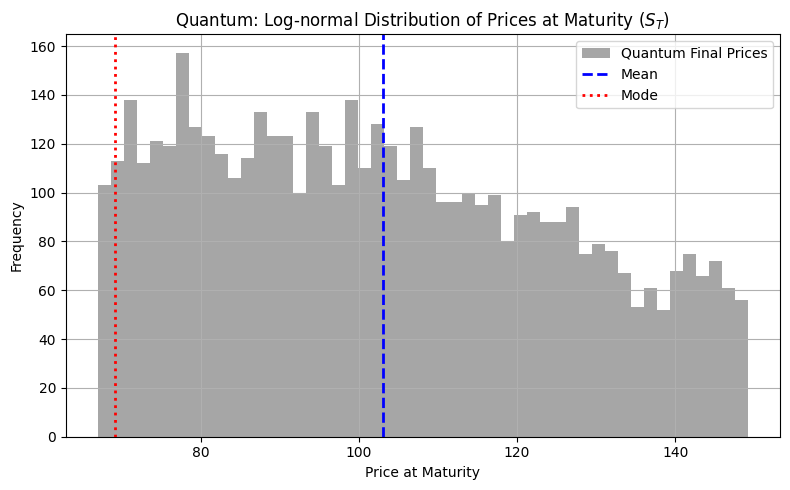

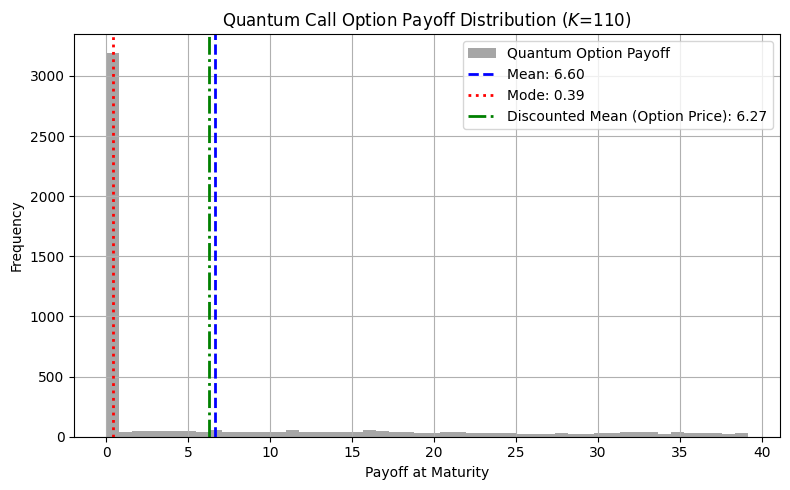


Strike (K) |    Quantum |   StdErr Q |         MC |  StdErr MC |  Black-Scholes
--------------------------------------------------------------------------------
        80 |    23.0466 |     0.2810 |    24.5616 |     0.0603 |        24.5888
        90 |    16.0758 |     0.2439 |    16.6642 |     0.0547 |        16.6994
       100 |    10.4840 |     0.1977 |    10.3994 |     0.0463 |        10.4506
       110 |     6.2734 |     0.1474 |     5.9891 |     0.0366 |         6.0401
       120 |     3.2863 |     0.0980 |     3.2075 |     0.0272 |         3.2475


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution
from scipy.stats import norm

# --- PARAMETERS ---
nq = 20        # Number of Qubits to be used!
nshots = 5000  # Shots in Quantum Simulator
S0 = 100       # Start Price of Underlying 100 USD
r = 0.05       # Risk Free Rate
sigma = 0.2    # Volatility of Underlying
T = 1.0        # Duration 1 year
strike = 110   # Strike Price 110 USD

mean = (r - 0.5 * sigma**2) * T + np.log(S0)
k = 2          # band width set to k=2 std deviations
stddev = sigma * np.sqrt(T)
low = S0 * np.exp(-k * stddev)
high = S0 * np.exp(k * stddev)
bounds = [(low, high)]

mu = [[mean]]
sigma_list = [[stddev]]
num_qubits = [nq]

# --- QUANTUM CIRCUIT ---
lognormal = LogNormalDistribution(
    num_qubits=num_qubits,
    mu=mu,
    sigma=sigma_list,
    bounds=bounds
)
qc = QuantumCircuit(nq)
qc.compose(lognormal, inplace=True)

# Add measurement
creg = ClassicalRegister(nq)
qc.add_register(creg)
qc.measure(range(nq), range(nq))

# --- QUANTUM SAMPLING ---
sampler = Sampler(run_options={"shots": nshots})
job = sampler.run([qc])
result = job.result()
dist = result.quasi_dists[0].binary_probabilities()

num_values = 2**nq
values = np.linspace(low, high, num_values)

# --- Quantum sampled final prices from bitstrings ---
final_prices = []
for bitstr, prob in dist.items():
    idx = int(bitstr, 2)
    s = values[idx]
    shots = int(prob * nshots)
    final_prices += [s] * shots
final_prices = np.array(final_prices)

# --- Quantum payoff calculation ---
payoffs = np.maximum(0, final_prices - strike)
expected_payoff = np.mean(payoffs)
discount_factor = np.exp(-r * T)
quantum_price = expected_payoff * discount_factor

print(f"Quantum-Estimated Price (K={strike}): {quantum_price:.4f}")

# --- Plot 1: Histogram of quantum-sampled final prices ---
plt.figure(figsize=(8, 5))
plt.hist(final_prices, bins=50, color='gray', alpha=0.7, label='Quantum Final Prices')
plt.axvline(np.mean(final_prices), color='blue', linestyle='--', linewidth=2, label='Mean')
plt.axvline(values[np.argmax(np.bincount([int((s-low)/(high-low)*num_values) for s in final_prices]))],
            color='red', linestyle=':', linewidth=2, label='Mode')
plt.title('Quantum: Log-normal Distribution of Prices at Maturity ($S_T$)')
plt.xlabel('Price at Maturity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Histogram of quantum payoffs ---
mean_payoff = np.mean(payoffs)
counts_payoff, bin_edges_payoff = np.histogram(payoffs, bins=50)
mode_index_payoff = np.argmax(counts_payoff)
mode_payoff = 0.5 * (bin_edges_payoff[mode_index_payoff] + bin_edges_payoff[mode_index_payoff + 1])
discounted_mean_payoff = mean_payoff * discount_factor

plt.figure(figsize=(8, 5))
plt.hist(payoffs, bins=50, color='gray', alpha=0.7, label='Quantum Option Payoff')
plt.axvline(mean_payoff, color='blue', linestyle='--', linewidth=2,
            label=f'Mean: {mean_payoff:.2f}')
plt.axvline(mode_payoff, color='red', linestyle=':', linewidth=2,
            label=f'Mode: {mode_payoff:.2f}')
plt.axvline(discounted_mean_payoff, color='green', linestyle='-.', linewidth=2,
            label=f'Discounted Mean (Option Price): {discounted_mean_payoff:.2f}')
plt.title(f'Quantum Call Option Payoff Distribution ($K$={strike})')
plt.xlabel('Payoff at Maturity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# --- Black-Scholes analytic price for comparison ---
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call


# --- CLASSICAL MONTE CARLO SIMULATION ---

num_mc_paths = 100000  # Number of MC paths
N = 252                # Number of time steps (as above)
dt = T / N

np.random.seed(42)     # For reproducibility
mc_final_prices = []
for _ in range(num_mc_paths):
    mc_returns = np.random.normal((r - 0.5 * sigma**2) * dt, sigma * np.sqrt(dt), N)
    mc_path = S0 * np.exp(np.cumsum(np.insert(mc_returns, 0, 0)))
    mc_final_prices.append(mc_path[-1])
mc_final_prices = np.array(mc_final_prices)

from scipy.stats import norm

# Example strikes, you can adjust as needed
Ks = [80, 90, 100, 110, 120]

print(f"\n{'Strike (K)':>10} | {'Quantum':>10} | {'StdErr Q':>10} | {'MC':>10} | {'StdErr MC':>10} | {'Black-Scholes':>14}")
print('-'*80)

for K in Ks:
    # Quantum
    q_payoffs = np.maximum(0, final_prices - K)
    n_quantum = len(q_payoffs)
    quantum_price = np.mean(q_payoffs) * discount_factor
    quantum_stderr = np.std(q_payoffs, ddof=1) / np.sqrt(n_quantum)
    quantum_stderr_discounted = quantum_stderr * discount_factor

    # MC
    mc_payoffs = np.maximum(0, mc_final_prices - K)
    n_mc = len(mc_payoffs)
    mc_price = np.mean(mc_payoffs) * discount_factor
    mc_stderr = np.std(mc_payoffs, ddof=1) / np.sqrt(n_mc)
    mc_stderr_discounted = mc_stderr * discount_factor

    # Black-Scholes
    bs_price = black_scholes_call(S0, K, T, r, sigma)

    print(f"{K:>10} | {quantum_price:>10.4f} | {quantum_stderr_discounted:>10.4f} | {mc_price:>10.4f} | {mc_stderr_discounted:>10.4f} | {bs_price:>14.4f}")
